In [1]:
# %matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import trades, plots, params, models, feats
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)
importlib.reload(feats)

<module 'libs.feats' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/feats.py'>

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import math

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import matplotlib.pyplot as plt   
import seaborn as sns
from pprint import pprint

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models.DayWindowDataset])
import torchmetrics

from tqdm.auto import tqdm
from typing import Tuple, Set, List, Union, Dict

import io
from PIL import Image
import IPython.display as disp

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)


In [3]:
df_feat_sel = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[params.features_cols_tick + ['bid','ask'] + [params.label_col]]
    
df_feat_sel

vwap_dev_15  bb_width_15    vol_15    rsi_15  stoch_k_15  \
2004-01-02 13:09:00    -0.040178    -1.574415 -1.470597 -2.557298   -1.785354   
2004-01-02 13:10:00    -0.048980    -1.545814 -1.466297 -2.557298   -1.785354   
2004-01-02 13:11:00    -0.056140    -1.516045 -1.463327 -2.557298   -1.785354   
2004-01-02 13:12:00    -0.061878    -1.485916 -1.461447 -2.557298   -1.785354   
2004-01-02 13:13:00    -0.066452    -1.456142 -1.460532 -2.557298   -1.785354   
...                          ...          ...       ...       ...         ...   
2025-06-18 20:56:00     1.066747     0.844220  0.884708  0.726751    0.700633   
2025-06-18 20:57:00     0.436767     0.825992  0.942109  0.484027    0.361998   
2025-06-18 20:58:00     0.331541     0.848628  0.919047  0.475468    0.340989   
2025-06-18 20:59:00    -1.002846     0.866409  1.231640 -0.145922   -0.857130   
2025-06-18 21:00:00     0.302116     0.800014  1.316801  0.193492    0.028185   

                     plus_di_15      r_15         bid         ask    signal  
2004-01-02 13:09:00   -1.346141 -0.025470    0.763664    0.764807  0.021536  
2004-01-02 13:10:00   -1.346141 -0.033444    0.763647    0.764790  0.023284  
2004-01-02 13:11:00   -1.346141 -0.041417    0.763631    0.764773  0.025175  
2004-01-02 13:12:00   -1.346141 -0.049391    0.763614    0.764757  0.027222  
2004-01-02 13:13:00   -1.346141 -0.057365    0.763597    0.764740  0.029436  
...                         ...       ...         ...         ...       ...  
2025-06-18 20:56:00    0.573679  1.323284  196.667400  196.962600  0.684908  
2025-06-18 20:57:00    0.495133  1.119932  196.527500  196.822500  0.612206  
2025-06-18 20:58:00    0.440310  0.832284  196.522500  196.817500  0.610468  
2025-06-18 20:59:00    0.210130 -0.094278  196.092800  196.387200  0.477090  
2025-06-18 21:00:00    0.002105  0.665797  196.392600  196.687400  0.350968  

[3605295 rows x 10 columns]

In [4]:
print('executing <build_lstm_tensors>...')
X, y_sig, y_ret, raw_close, raw_bid, raw_ask, end_times = models.build_lstm_tensors(
    df            = df_feat_sel,
    sess_start    = params.sess_start_pred_tick 
)

print('executing <chronological_split>...')
(
(X_tr,  y_sig_tr,  y_ret_tr),
(X_val, y_sig_val, y_ret_val),
(X_te,  y_sig_te,  y_ret_te,  raw_close_te, raw_bid_te, raw_ask_te),
samples_per_day,
day_id_tr, day_id_val, day_id_te
) = models.chronological_split(
    X, y_sig, y_ret,
    raw_close, raw_bid, raw_ask,
    end_times   = end_times,
    train_prop  = params.train_prop,
    val_prop    = params.val_prop,
    train_batch = params.hparams['TRAIN_BATCH']
)

# carve `end_times` into the same three splits:
n_tr  = day_id_tr .shape[0] 
n_val = day_id_val.shape[0]
i_tr  = n_tr
i_val = n_tr + n_val

end_times_tr  = end_times[:i_tr]
end_times_val = end_times[i_tr:i_val]
end_times_te  = end_times[i_val:]

print('executing <split_to_day_datasets>...')
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # train split:   
    X_tr,            y_sig_tr,     y_ret_tr,   end_times_tr,
    # val split:
    X_val,           y_sig_val,    y_ret_val,  end_times_val,
    # test split + raw‐prices
    X_te,            y_sig_te,     y_ret_te,   end_times_te,
    raw_close_te, raw_bid_te, raw_ask_te,
    
    sess_start_time       = params.sess_start_pred_tick,
    signal_thresh         = params.best_optuna_params["buy_threshold"],
    return_thresh         = 0.01,  # flat‐zone threshold for returns
    train_batch           = params.hparams["TRAIN_BATCH"],
    train_workers         = params.hparams["NUM_WORKERS"],
    train_prefetch_factor = params.hparams["TRAIN_PREFETCH_FACTOR"]
)

# how many calendar-days in each split?
print("Days →",
      f"train={len(train_loader.dataset)},",
      f"val={len(val_loader.dataset)},",
      f"test={len(test_loader.dataset)}")

# how many sliding-windows in each split?
print("Windows →",
      f"train={train_loader.dataset.X.shape[0]},",
      f"val={val_loader.dataset.X.shape[0]},",
      f"test={test_loader.dataset.X.shape[0]}")

# how many batches per loader?
print("Batches →",
      f"train={len(train_loader)},",
      f"val={len(val_loader)},",
      f"test={len(test_loader)}")

executing <build_lstm_tensors>...
Inside build_lstm_tensors, using: ['vwap_dev_15', 'bb_width_15', 'vol_15', 'rsi_15', 'stoch_k_15', 'plus_di_15', 'r_15']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

executing <chronological_split>...
executing <split_to_day_datasets>...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Days → train=3840, val=751, test=809
Windows → train=1716386, val=338701, test=364692
Batches → train=60, val=751, test=809


Loading checkpoint: trainings/AAPL_0.2495.pth

Hyperparameters:
{'ATT_DROPOUT': 0.2,
 'ATT_HEADS': 4,
 'CLIPNORM': 1,
 'CLS_LOSS_WEIGHT': 0.05,
 'DROPOUT_LONG': 0.2,
 'DROPOUT_SHORT': 0.2,
 'EARLY_STOP_PATIENCE': 6,
 'ETA_MIN': 1e-06,
 'HUBER_BETA': 0.1,
 'INITIAL_LR': 5e-05,
 'LONG_UNITS': 64,
 'LR_EPOCHS_WARMUP': 3,
 'MAX_EPOCHS': 90,
 'MIN_LR': 1e-06,
 'NUM_WORKERS': 4,
 'PLATEAU_FACTOR': 0.9,
 'PLATEAU_PATIENCE': 0,
 'PLAT_EPOCHS_WARMUP': 999,
 'SHORT_UNITS': 64,
 'TRAIN_BATCH': 64,
 'TRAIN_PREFETCH_FACTOR': 2,
 'T_0': 90,
 'T_MULT': 1,
 'VAL_BATCH': 1,
 'WEIGHT_DECAY': 5e-05}


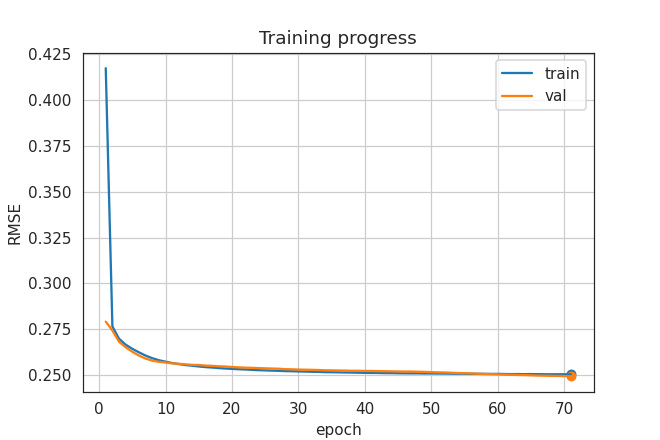


Train metrics: {'rmse': 0.2505040466785431, 'mae': 0.18988975882530212, 'r2': 0.25490885972976685, 'acc': 0.2817344069480896, 'prec': 0.26309430599212646, 'rec': 0.8864953517913818, 'f1': 0.40576544404029846, 'auroc': 0.45369482040405273}
 Val metrics: {'rmse': 0.249471977353096, 'mae': 0.17875218391418457, 'r2': 0.24448496103286743, 'acc': 0.2856265604496002, 'prec': 0.2713208496570587, 'rec': 0.8818596601486206, 'f1': 0.41496869921684265, 'auroc': 0.4637881815433502}


DualMemoryLSTM(
  (conv): Conv1d(7, 7, kernel_size=(3,), stride=(1,), padding=(1,))
  (short_lstm): LSTM(7, 32, batch_first=True, bidirectional=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (do_short): Dropout(p=0.2, inplace=False)
  (ln_short): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(64, 32, batch_first=True, bidirectional=True)
  (do_long): Dropout(p=0.2, inplace=False)
  (ln_long): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=64, out_features=1, bias=True)
  (cls_head): Linear(in_features=64, out_features=1, bias=True)
  (cls_ter): Linear(in_features=64, out_features=3, bias=True)
)

In [5]:
device = params.device

# 1) Pick the best checkpoint file
model_path = min(
    Path(params.models_folder).glob(f"{params.ticker}_*.pth"),
    key=lambda p: float(p.stem.split("_")[-1])
)
print("Loading checkpoint:", model_path)

# 2) Load the on-disk dict (all tensors on CPU, no code executed)
ckpt = torch.load(model_path, map_location="cpu", weights_only=False)

# 3) Inspect metadata, plots, metrics
print("\nHyperparameters:")
pprint(ckpt["hparams"])

if "train_plot_png" in ckpt:
    img = Image.open(io.BytesIO(ckpt["train_plot_png"]))
    display(img)

print("\nTrain metrics:", ckpt["train_metrics"])
print(  " Val metrics:", ckpt["val_metrics"])

# 4) Reinstantiate a *clean* model in CPU memory
model_best = models.DualMemoryLSTM(
    n_feats       = X.shape[-1],    
    short_units   = ckpt["hparams"]["SHORT_UNITS"],
    long_units    = ckpt["hparams"]["LONG_UNITS"],
    dropout_short = ckpt["hparams"]["DROPOUT_SHORT"],
    dropout_long  = ckpt["hparams"]["DROPOUT_LONG"],
    att_heads     = ckpt["hparams"]["ATT_HEADS"],
    att_drop      = ckpt["hparams"]["ATT_DROPOUT"]
)

# 5) Load *only* the weight tensors into that fresh model
model_best.load_state_dict(ckpt["model_state_dict"])

# 6) Finally—and only now—move to GPU (or keep on CPU)
model_best.to(device)
model_best.eval()

# 7) Ready for inference!
model_best


In [6]:
# -----------------------------------------------------------------------------
# Helper: extract the true signal 'y' from any loader into a flat array
# -----------------------------------------------------------------------------
def extract_y(loader):
    return np.concatenate([
        batch[1].cpu().numpy().ravel()
        for batch in loader
    ])

# pull out validation & test targets
y_val  = extract_y(val_loader)
y_test = extract_y(test_loader)

# -----------------------------------------------------------------------------
# 1) Zero‐forecast baseline RMSE:
#    – predict 0 always → RMSE_zero = sqrt(mean(y²))
# -----------------------------------------------------------------------------
rmse_zero_val  = np.sqrt(np.mean(y_val ** 2))
rmse_zero_test = np.sqrt(np.mean(y_test ** 2))

print(f"Zero‐forecast RMSE (predict 0) → val:  {rmse_zero_val:.6f}")
print(f"                            test: {rmse_zero_test:.6f}\n")

# -----------------------------------------------------------------------------
# 2) Compute mean, variance & std of val/test signals
#    – and report the mean‐predictor baseline (RMSE=std,   R²=0)
# -----------------------------------------------------------------------------
for split_name, y in [("Validation", y_val), ("Test", y_test)]:
    mean   = y.mean()
    std    = y.std(ddof=0)      # population std = sqrt(var)
    var    = std ** 2
    rmse_m = std               # RMSE_baseline = std(y)
    
    print(f"{split_name} target stats:")
    print(f"  mean = {mean:.4f}, var = {var:.4f}, std = {std:.4f}")
    print(f"{split_name} mean‐predictor baseline:")
    print(f"  RMSE_baseline = {rmse_m:.6f}")
    print("  R²_baseline    = 0.00\n")


Zero‐forecast RMSE (predict 0) → val:  0.409382
                            test: 0.391563

Validation target stats:
  mean = 0.2919, var = 0.0824, std = 0.2870
Validation mean‐predictor baseline:
  RMSE_baseline = 0.287012
  R²_baseline    = 0.00

Test target stats:
  mean = 0.2780, var = 0.0760, std = 0.2757
Test mean‐predictor baseline:
  RMSE_baseline = 0.275706
  R²_baseline    = 0.00



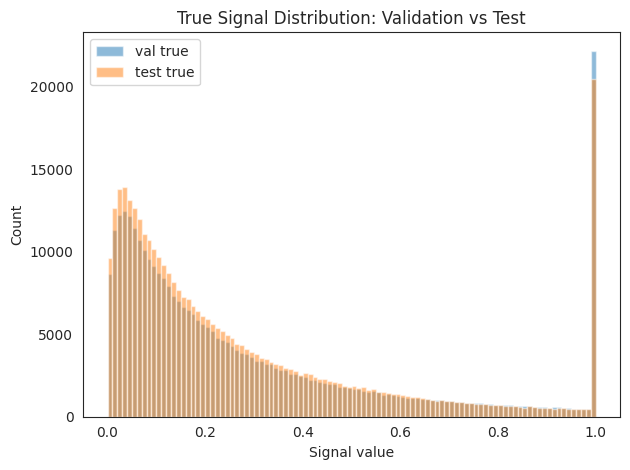

In [7]:
# Visualize the true‐signal distributions on validation vs. test
plt.hist(y_val,   bins=100, alpha=0.5, label="val true")
plt.hist(y_test, bins=100, alpha=0.5, label="test true")

plt.xlabel("Signal value")
plt.ylabel("Count")
plt.title("True Signal Distribution: Validation vs Test")
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
def make_preds_and_eval(model, loader, device, split_name: str):
    """
    Run inference over a DataLoader for a stateful CNN→BiLSTM→Attention→BiLSTM model 
    with three heads (regression, binary, ternary), compute metrics, and collect predictions.

    Functionality:
      1) Put model in eval mode and reset LSTM hidden states.
      2) Create torchmetrics objects for:
         - regression: RMSE, MAE, R2
         - binary (sig > threshold): accuracy, precision, recall, F1, AUROC
         - ternary (down/flat/up): multiclass accuracy, precision, recall, F1, AUROC
      3) For each batch in loader (no grad):
         a) Unpack padded sequences, move to device.
         b) For each sequence in the batch:
            • Slice to its true length.
            • Reset or carry LSTM states on day rollover.
            • Forward pass → raw_reg, raw_bin, raw_ter logits.
            • Sigmoid‐activate the regression head so pr ∈ [0,1].
            • Sigmoid/softmax the other heads for probabilities.
            • Update all metrics on the unpadded windows.
            • Append pr to the predictions list.
      4) After looping, compute final metric values.
      5) Print metrics in the format:
         R: … | B: … | T: …
      6) Return (metrics_dict, concatenated_predictions).

    Returns:
      metrics_dict: Dict[str, float] of computed metrics.
      all_preds:    numpy array of all sigmoid’d regression outputs.
    """
    # 1) Prepare model
    model.to(device).eval()
    model.h_short = model.h_long = None

    # 2) Instantiate metrics on target device
    thr        = 0.5
    rmse_m     = torchmetrics.MeanSquaredError(squared=False).to(device)
    mae_m      = torchmetrics.MeanAbsoluteError().to(device)
    r2_m       = torchmetrics.R2Score().to(device)

    acc_m      = torchmetrics.classification.BinaryAccuracy(threshold=thr).to(device)
    prec_m     = torchmetrics.classification.BinaryPrecision(threshold=thr).to(device)
    rec_m      = torchmetrics.classification.BinaryRecall(threshold=thr).to(device)
    f1_m       = torchmetrics.classification.BinaryF1Score(threshold=thr).to(device)
    auc_m      = torchmetrics.classification.BinaryAUROC().to(device)

    ter_acc_m  = torchmetrics.classification.MulticlassAccuracy(num_classes=3).to(device)
    ter_prec_m = torchmetrics.classification.MulticlassPrecision(num_classes=3, average="macro").to(device)
    ter_rec_m  = torchmetrics.classification.MulticlassRecall(num_classes=3, average="macro").to(device)
    ter_f1_m   = torchmetrics.classification.MulticlassF1Score(num_classes=3, average="macro").to(device)
    ter_auc_m  = torchmetrics.classification.MulticlassAUROC(num_classes=3, average="macro").to(device)

    # Reset all metrics
    for m in (
        rmse_m, mae_m, r2_m,
        acc_m, prec_m, rec_m, f1_m, auc_m,
        ter_acc_m, ter_prec_m, ter_rec_m, ter_f1_m, ter_auc_m
    ):
        m.reset()

    all_preds = []
    prev_day  = None

    # 3) Loop over batches without gradient tracking
    with torch.no_grad():
        for batch in tqdm(loader, desc=split_name, unit="batch"):
            # Unpack batch (11‐tuple or 8‐tuple)
            if len(batch) == 11:
                xb, y_reg, y_bin, y_ret, y_ter, rc, rb, ra, wd, ts_list, lengths = batch
            else:
                xb, y_reg, y_bin, y_ret, y_ter, wd, ts_list, lengths = batch

            # Move to device
            xb    = xb.to(device, non_blocking=True)
            y_reg = y_reg.to(device, non_blocking=True)
            y_bin = y_bin.to(device, non_blocking=True)
            y_ret = y_ret.to(device, non_blocking=True)
            y_ter = y_ter.to(device, non_blocking=True)
            wd    = wd.to(device, non_blocking=True)

            B = xb.size(0)
            for i in range(B):
                W_true = lengths[i]
                day_id = int(wd[i].item())

                # reset or carry LSTM states on new day
                model.reset_short()
                if prev_day is not None and day_id < prev_day:
                    model.reset_long()
                prev_day = day_id

                # Slice sequences to true length
                x_day = xb[i, :W_true]
                y_day = y_reg[i, :W_true].view(-1)
                bin_t = y_bin[i, :W_true].view(-1)
                ter_t = y_ter[i, :W_true].view(-1)

                # Forward pass to get raw logits
                raw_reg, raw_bin, raw_ter = model(x_day)

                # ← FIX: apply sigmoid so regression outputs ∈ [0,1]
                pr = torch.sigmoid(raw_reg[..., -1, 0])    # (W_true,)

                # Binary & ternary probabilities
                pb = torch.sigmoid(raw_bin[..., -1, 0])     # (W_true,)
                pt = torch.softmax(raw_ter[..., -1, :], dim=-1)  # (W_true,3)

                # Update metrics
                rmse_m.update(pr, y_day)
                mae_m .update(pr, y_day)
                r2_m  .update(pr, y_day)

                acc_m .update(pb,  bin_t)
                prec_m.update(pb,  bin_t)
                rec_m .update(pb,  bin_t)
                f1_m  .update(pb,  bin_t)
                auc_m .update(pb,  bin_t)

                ter_acc_m .update(pt, ter_t)
                ter_prec_m.update(pt, ter_t)
                ter_rec_m .update(pt, ter_t)
                ter_f1_m  .update(pt, ter_t)
                ter_auc_m .update(pt, ter_t)

                # Collect predictions
                all_preds.append(pr.cpu().numpy())

    # 4) Compute and gather final metrics
    metrics = {
        "rmse":  rmse_m.compute().item(),
        "mae":   mae_m.compute().item(),
        "r2":    r2_m.compute().item(),
        "acc":   acc_m.compute().item(),
        "prec":  prec_m.compute().item(),
        "rec":   rec_m.compute().item(),
        "f1":    f1_m.compute().item(),
        "auroc": auc_m.compute().item(),
        "t_acc":  ter_acc_m.compute().item(),
        "t_prec": ter_prec_m.compute().item(),
        "t_rec":  ter_rec_m.compute().item(),
        "t_f1":   ter_f1_m.compute().item(),
        "t_auc":  ter_auc_m.compute().item()
    }

    # 5) Print in the R | B | T format
    print(
        f"{split_name}→ "
        f'"R": RMSE={metrics["rmse"]:.5f} MAE={metrics["mae"]:.5f} R2={metrics["r2"]:.4f} | '
        f'"B": Acc={metrics["acc"]:.4f} Prec={metrics["prec"]:.4f} Rec={metrics["rec"]:.4f} '
           f'F1={metrics["f1"]:.4f} AUROC={metrics["auroc"]:.4f} | '
        f'"T": Acc={metrics["t_acc"]:.4f} Prec={metrics["t_prec"]:.4f} Rec={metrics["t_rec"]:.4f} '
           f'F1={metrics["t_f1"]:.4f} AUROC={metrics["t_auc"]:.4f}'
    )

    # Return metrics dict and concatenated predictions
    return metrics, np.concatenate(all_preds, axis=0)


In [9]:
# Run evaluation on all three splits
train_metrics, train_preds = make_preds_and_eval(
    model_best, train_loader, device, split_name="TRAIN"
)
val_metrics, val_preds     = make_preds_and_eval(
    model_best, val_loader,   device, split_name="VALID"
)
test_metrics, test_preds   = make_preds_and_eval(
    model_best, test_loader,  device, split_name="TEST"
)

print("\nPredictions lengths:")
print(f"  Train: {len(train_preds)}")
print(f"  Valid: {len(val_preds)}")
print(f"  Test : {len(test_preds)}")


TRAIN:   0%|          | 0/60 [00:00<?, ?batch/s]

TRAIN→ "R": RMSE=0.25110 MAE=0.18188 R2=0.2514 | "B": Acc=0.2740 Prec=0.2630 Rec=0.9010 F1=0.4071 AUROC=0.4743 | "T": Acc=0.1871 Prec=0.3321 Rec=0.1871 F1=0.0170 AUROC=0.2369


VALID:   0%|          | 0/751 [00:00<?, ?batch/s]

VALID→ "R": RMSE=0.24947 MAE=0.17875 R2=0.2445 | "B": Acc=0.2856 Prec=0.2713 Rec=0.8819 F1=0.4150 AUROC=0.4638 | "T": Acc=0.1463 Prec=0.3320 Rec=0.1463 F1=0.0157 AUROC=0.1903


TEST:   0%|          | 0/809 [00:00<?, ?batch/s]

TEST→ "R": RMSE=0.24430 MAE=0.17472 R2=0.2149 | "B": Acc=0.2739 Prec=0.2559 Rec=0.8816 F1=0.3967 AUROC=0.4610 | "T": Acc=0.1391 Prec=0.3324 Rec=0.1391 F1=0.0128 AUROC=0.2488

Predictions lengths:
  Train: 1716386
  Valid: 338701
  Test : 364692


In [10]:
# Train metrics: {'rmse': 0.2511899769306183, 'mae': 0.1913333684206009, 'r2': 0.25082170963287354, 'acc': 0.6048908829689026, 'prec': 0.37061670422554016, 'rec': 0.6134570240974426, 'f1': 0.4620739817619324, 'auroc': 0.6534450054168701}
#  Val metrics: {'rmse': 0.2520979940891266, 'mae': 0.18592233955860138, 'r2': 0.22849565744400024, 'acc': 0.6560742259025574, 'prec': 0.43357253074645996, 'rec': 0.6432564854621887, 'f1': 0.5179992914199829, 'auroc': 0.7046865224838257}

In [11]:
def add_preds_and_split(
    df: pd.DataFrame,
    train_preds: np.ndarray,
    val_preds:   np.ndarray,
    test_preds:  np.ndarray,
    end_times_tr:  np.ndarray,   # timestamps for training-window ends
    end_times_val: np.ndarray,   # timestamps for validation-window ends
    end_times_te:  np.ndarray    # timestamps for test-window ends
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    1) Copy minute‐bar DataFrame and append:
         • 'pred_signal' (continuous model output at each window end)
         • 'close_mid'    (mid‐price from bid & ask for sim price)
    2) Build three timestamp→prediction Series for train/val/test.
    3) Stamp each Series into df2['pred_signal'], warning on missing indices.
    4) Split df2 into:
         • df_trainval: rows with train or val window‐end indices
         • df_test:     rows with test window‐end indices
       and drop any NaNs in 'pred_signal'.
    5) Return (df_trainval, df_test).
    """
    # 1) Copy & initialize pred_signal + mid‐price
    df2 = df.copy()
    df2["pred_signal"] = np.nan
    # mid‐price for trade simulation
    df2["close_mid"] = (df2["bid"] + df2["ask"]) / 2

    # 2) Build prediction Series with DatetimeIndex
    s_tr  = pd.Series(train_preds, index=pd.DatetimeIndex(end_times_tr))
    s_val = pd.Series(val_preds,   index=pd.DatetimeIndex(end_times_val))
    s_te  = pd.Series(test_preds,  index=pd.DatetimeIndex(end_times_te))

    # internal helper to stamp preds into df2
    def _stamp(series: pd.Series, label: str):
        missing = series.index.difference(df2.index)
        if not missing.empty:
            print(f"⚠️ {label}: {len(missing)} timestamps not found in DataFrame")
        valid = series.index.intersection(df2.index)
        df2.loc[valid, "pred_signal"] = series.loc[valid].values

    # 3) Stamp train, val, test predictions
    _stamp(s_tr,  "Train")
    _stamp(s_val, "Val")
    _stamp(s_te,  "Test")
    print(f"✅ Stamped {len(s_tr)} Train, {len(s_val)} Val, {len(s_te)} Test predictions")

    # 4) Split and drop NaNs in pred_signal
    idx_trval = s_tr.index.union(s_val.index).intersection(df2.index)
    idx_te    = s_te.index.intersection(df2.index)

    df_trainval = df2.loc[idx_trval].dropna(subset=["pred_signal"])
    df_test     = df2.loc[idx_te].dropna(subset=["pred_signal"])

    print(f"➡️  train+val: {len(df_trainval)} rows, test: {len(df_test)} rows")
    return df_trainval, df_test


In [12]:
# 1) Stamp predictions and mid‐price, then split into train+val & test
df_trainval, df_test = add_preds_and_split(
    df            = df_feat_sel,
    train_preds   = train_preds,
    val_preds     = val_preds,
    test_preds    = test_preds,
    end_times_tr  = end_times_tr,
    end_times_val = end_times_val,
    end_times_te  = end_times_te
)

# 2) Persist CSVs
print("Saving test CSV…")
df_test.to_csv(params.test_csv)
print("Saving train+val CSV…")
df_trainval.to_csv(params.trainval_csv)

df_test

✅ Stamped 1716386 Train, 338701 Val, 364692 Test predictions
➡️  train+val: 2055087 rows, test: 364692 rows
Saving test CSV…
Saving train+val CSV…


vwap_dev_15  bb_width_15    vol_15    rsi_15  stoch_k_15  \
2022-03-29 13:30:00     0.784719     1.240419  0.241528  0.802460    1.095443   
2022-03-29 13:31:00     0.606540     1.176700  0.211109  0.735817    1.034641   
2022-03-29 13:32:00     0.529847     1.082740  0.213910  0.752924    1.059410   
2022-03-29 13:33:00     0.257686     0.877828  0.232043  0.576845    0.883271   
2022-03-29 13:34:00     0.403091     0.565675  0.231104  0.673481    1.029067   
...                          ...          ...       ...       ...         ...   
2025-06-18 20:56:00     1.066747     0.844220  0.884708  0.726751    0.700633   
2025-06-18 20:57:00     0.436767     0.825992  0.942109  0.484027    0.361998   
2025-06-18 20:58:00     0.331541     0.848628  0.919047  0.475468    0.340989   
2025-06-18 20:59:00    -1.002846     0.866409  1.231640 -0.145922   -0.857130   
2025-06-18 21:00:00     0.302116     0.800014  1.316801  0.193492    0.028185   

                     plus_di_15      r_15       bid       ask    signal  \
2022-03-29 13:30:00    0.117318  1.524499  176.7573  177.0227  0.126781   
2022-03-29 13:31:00    0.095382  1.194106  176.7373  177.0027  0.089210   
2022-03-29 13:32:00    0.036893  1.173390  176.7473  177.0127  0.067235   
2022-03-29 13:33:00    0.013935  1.132417  176.6974  176.9626  0.080207   
2022-03-29 13:34:00   -0.079546  1.194039  176.7473  177.0127  0.110511   
...                         ...       ...       ...       ...       ...   
2025-06-18 20:56:00    0.573679  1.323284  196.6674  196.9626  0.684908   
2025-06-18 20:57:00    0.495133  1.119932  196.5275  196.8225  0.612206   
2025-06-18 20:58:00    0.440310  0.832284  196.5225  196.8175  0.610468   
2025-06-18 20:59:00    0.210130 -0.094278  196.0928  196.3872  0.477090   
2025-06-18 21:00:00    0.002105  0.665797  196.3926  196.6874  0.350968   

                     pred_signal  close_mid  
2022-03-29 13:30:00     0.476918    176.890  
2022-03-29 13:31:00     0.430929    176.870  
2022-03-29 13:32:00     0.354458    176.880  
2022-03-29 13:33:00     0.339264    176.830  
2022-03-29 13:34:00     0.282731    176.880  
...                          ...        ...  
2025-06-18 20:56:00     0.456752    196.815  
2025-06-18 20:57:00     0.526851    196.675  
2025-06-18 20:58:00     0.361646    196.670  
2025-06-18 20:59:00     0.302006    196.240  
2025-06-18 21:00:00     0.197897    196.540  

[364692 rows x 12 columns]

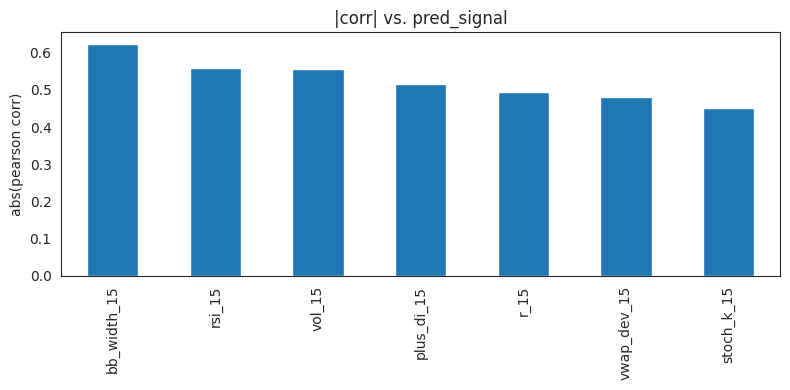

bb_width_15    0.623192
rsi_15         0.557759
vol_15         0.556784
plus_di_15     0.515498
r_15           0.494716
vwap_dev_15    0.481277
stoch_k_15     0.450974
dtype: float64

In [13]:
# Quick correlation check
# This measures the absolute Pearson corr between each feature and the pred_signal on the test split

# Identify feature columns (drop non-inputs)
feat_cols = [
    c for c in df_test.columns
    if c not in ("bid","ask","signal","pred_signal","close_mid")
]

# Compute absolute corr(feature, pred_signal)
corrs = df_test[feat_cols] \
    .corrwith(df_test["pred_signal"]) \
    .abs() \
    .sort_values(ascending=False)

# Bar plot
corrs.plot.bar(figsize=(8,4), title="|corr| vs. pred_signal")
plt.ylabel("abs(pearson corr)")
plt.tight_layout()
plt.show()

corrs

IG windows:   0%|          | 0/40 [00:00<?, ?it/s]

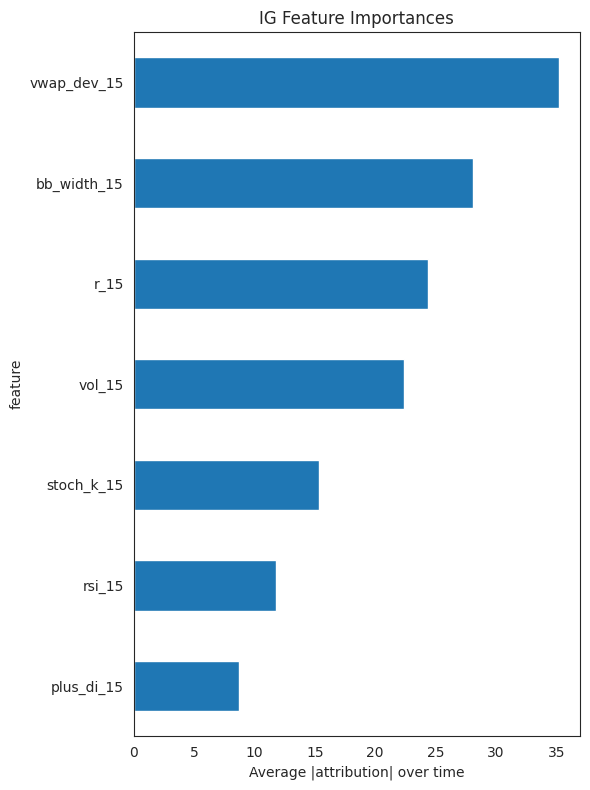

feature  importance
0  vwap_dev_15   35.197504
1  bb_width_15   28.124239
6         r_15   24.348662
2       vol_15   22.422071
4   stoch_k_15   15.379891
3       rsi_15   11.785171
5   plus_di_15    8.739996

In [14]:
# — Integrated-Gradients (Captum) AFTER add_preds_and_split and loading model_best —
feature_names = [
    c for c in df_test.columns
    if c not in ("bid","ask","signal","pred_signal","close_mid")
]

imp_df = feats.ig_feature_importance(
    model_best,
    test_loader,
    feature_names,
    device,
    n_samples=40,    # how many windows to sample
    n_steps=20       # fewer steps → less mem & time
)

# Simple horizontal bar plot
plt.figure(figsize=(6,8))
imp_df \
    .set_index("feature")["importance"] \
    .sort_values() \
    .plot.barh(color="C0")
plt.title("IG Feature Importances")
plt.xlabel("Average |attribution| over time")
plt.tight_layout()
plt.show()

imp_df


In [15]:
# Compute Descriptive Statistics
# Statistics show whether the model systematically over/under-estimates (compare means) and how tightly it tracks (std & correlation).

# assume df is your DataFrame
stats = df_test[['signal','pred_signal']].describe().T

# add range and error
stats['range'] = stats['max'] - stats['min']
corr = df_test['signal'].corr(df_test['pred_signal'])
stats['pearson_r_with_other'] = [corr, corr]

stats

count      mean       std       min       25%       50%  \
signal       364692.0  0.278042  0.275707  0.000000  0.073041  0.177408   
pred_signal  364692.0  0.238808  0.147791  0.051716  0.132235  0.195415   

                  75%       max     range  pearson_r_with_other  
signal       0.388009  1.000000  1.000000              0.487337  
pred_signal  0.299397  0.935773  0.884057              0.487337

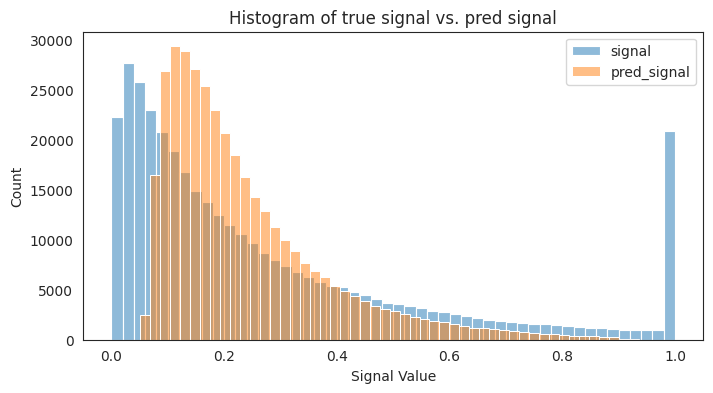

In [16]:
# Distribution Overlay
# Histogram overlay reveals any bias or mismatched shape in the two distributions.

plt.figure(figsize=(8,4))
sns.histplot(df_test['signal'], color='C0', alpha=0.5, bins=50, label='signal')
sns.histplot(df_test['pred_signal'],   color='C1', alpha=0.5, bins=50, label='pred_signal')
plt.legend()
plt.xlabel('Signal Value')
plt.ylabel('Count')
plt.title('Histogram of true signal vs. pred signal')
plt.show()

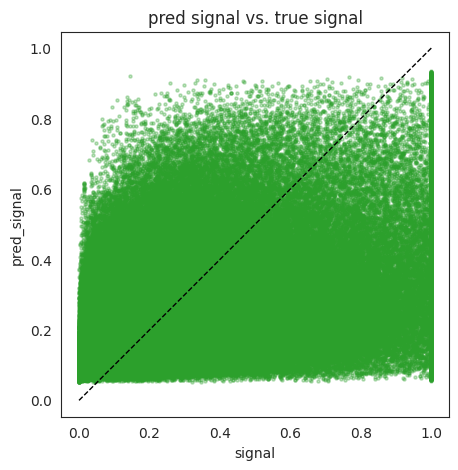

In [17]:
# Scatter Plot: Relationship
# Scatter against the 45° line instantly shows under/over‐prediction regions and non‐linear errors.

plt.figure(figsize=(5,5))
plt.scatter(df_test['signal'], df_test['pred_signal'],
            s=5, alpha=0.3, color='C2')
plt.plot([0,1],[0,1], 'k--', linewidth=1)  # 45° reference line
plt.xlabel('signal')
plt.ylabel('pred_signal')
plt.title('pred signal vs. true signal')
plt.axis('equal')
plt.show()

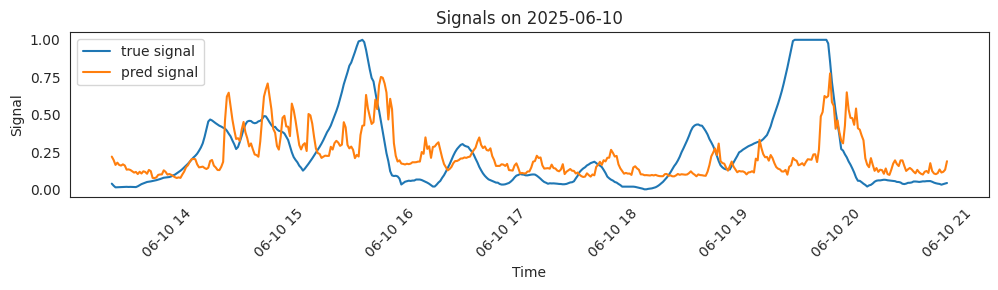

In [18]:
# pick a random trading day from the test set
all_days = df_test.index.normalize().unique()
day      = np.random.choice(all_days)

# mask for that day
mask = df_test.index.normalize() == day

# Plot true vs. predicted signal on the random day
plt.figure(figsize=(10, 3))
plt.plot(df_test.index[mask], df_test.loc[mask, 'signal'],      label='true signal')
plt.plot(df_test.index[mask], df_test.loc[mask, 'pred_signal'], label='pred signal')
plt.legend(loc='upper left')
plt.title(f'Signals on {pd.to_datetime(day).date()}')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

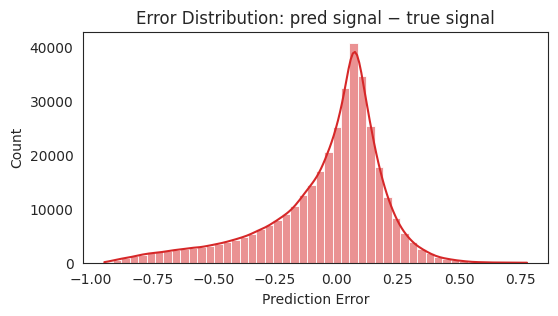

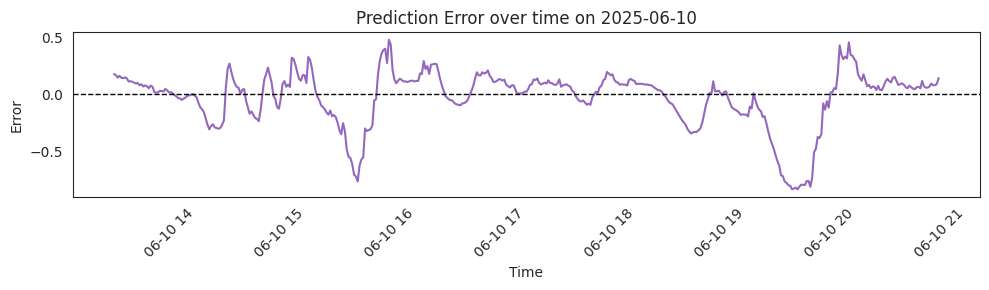

In [19]:
# Error Analysis 
# Error plots quantify where and when the model struggles most, guiding you to fix lag, amplitude scaling, or threshold issues.

# create error column
df_test['error'] = df_test['pred_signal'] - df_test['signal']

# Distribution of prediction error
plt.figure(figsize=(6,3))
sns.histplot(df_test['error'], bins=50, color='C3', kde=True)
plt.xlabel('Prediction Error')
plt.title('Error Distribution: pred signal − true signal')
plt.show()

# Time evolution of error on that same sample day
plt.figure(figsize=(10,3))
plt.plot(df_test.index[mask], df_test.loc[mask,'error'], color='C4')
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.title(f'Prediction Error over time on {pd.to_datetime(day).date()}')
plt.xlabel('Time')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [32]:
importlib.reload(params) ##########

# If running generate_trade_actions on a multi-day block, the in_trade flag won’t reset at midnight. Splitting by day below avoids that.
# Simulate per‐day to avoid cross‐midnight state carry‐over
sim_results = {}
groups     = list(df_test.groupby(df_test.index.normalize()))
print(f"Processing {len(groups)} days of predictions…")

for day, df_day in tqdm(groups, desc="Generate+Simulate"):
    # a) Generate discrete actions from the continuous signal
    df_actions = trades.generate_trade_actions(
        df                = df_day,
        col_signal        = "pred_signal", # name for the signal column to use
        col_action        = "pred_action", # name for the trade-action column to add
        buy_threshold     = params.pred_threshold_tick,
        trailing_stop_pct = params.trailing_stop_pred_tick,
        sess_start        = params.sess_start,
        col_close         = "close_mid",    # name of the column to use for price
    )

    # b) Run the backtest on this single‐day DataFrame
    single_result = trades.simulate_trading(
        results_by_day_sign = {day: (df_actions, [])},
        col_action          = "pred_action",
        sess_start          = params.sess_start,
        sess_end            = params.sess_end
    )
    sim_results.update(single_result)

# final: sim_results holds each day → (df_sim, trades, stats)


Processing 809 days of predictions…


Generate+Simulate:   0%|          | 0/809 [00:00<?, ?it/s]


Plotting days in 2023-10:



=== Performance for 2023-10-02 00:00:00 ===
Buy & Hold Return ($): 2.381
Strategy Return ($): -0.024
Trades Returns ($): [-0.005, -0.111, 0.033, 0.059]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-10-03 00:00:00 ===
Buy & Hold Return ($): -0.449
Strategy Return ($): -0.973
Trades Returns ($): [-0.199, -0.347, -0.187, -0.238]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-10-04 00:00:00 ===
Buy & Hold Return ($): 1.601
Strategy Return ($): -2.235
Trades Returns ($): [-0.284, -0.419, -0.528, -0.37, 0.05, -0.409, -0.186, -0.09]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-10-05 00:00:00 ===
Buy & Hold Return ($): 0.668
Strategy Return ($): -1.453
Trades Returns ($): [-0.312, -0.451, -0.341, 0.002, -0.352]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-10-06 00:00:00 ===
Buy & Hold Return ($): 2.651
Strategy Return ($): -1.889
Trades Returns ($): [-0.833, -0.48, -0.291, 0.028, -0.383, -0.252, -0.321, 0.646]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-10-09 00:00:00 ===
Buy & Hold Return ($): 1.899
Strategy Return ($): -1.249
Trades Returns ($): [0.044, -0.456, -0.246, 0.174, -0.153, -0.268, -0.344]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-10-10 00:00:00 ===
Buy & Hold Return ($): -0.393
Strategy Return ($): -1.621
Trades Returns ($): [-0.641, -0.249, -0.348, -0.384]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-10-11 00:00:00 ===
Buy & Hold Return ($): 1.221
Strategy Return ($): -1.733
Trades Returns ($): [-0.308, -0.345, -0.183, -0.395, -0.504]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-10-12 00:00:00 ===
Buy & Hold Return ($): 0.429
Strategy Return ($): -0.642
Trades Returns ($): [0.317, -0.523, -0.436]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-10-13 00:00:00 ===
Buy & Hold Return ($): -3.27
Strategy Return ($): -0.493
Trades Returns ($): [-0.494]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-10-16 00:00:00 ===
Buy & Hold Return ($): 1.788
Strategy Return ($): -2.704
Trades Returns ($): [-0.366, -0.386, -0.477, -0.456, -0.102, -0.377, -0.539]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-10-17 00:00:00 ===
Buy & Hold Return ($): -0.026
Strategy Return ($): -2.035
Trades Returns ($): [-0.174, -0.539, -0.429, -0.238, -0.407, -0.027, -0.223]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-10-18 00:00:00 ===
Buy & Hold Return ($): -0.233
Strategy Return ($): -2.508
Trades Returns ($): [-0.394, -0.276, -0.547, -0.505, -0.412, -0.376]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-10-19 00:00:00 ===
Buy & Hold Return ($): -1.084
Strategy Return ($): -1.313
Trades Returns ($): [-0.301, -0.211, -0.571, -0.816, 0.585]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-10-20 00:00:00 ===
Buy & Hold Return ($): -2.311
Strategy Return ($): -1.12
Trades Returns ($): [-0.493, -0.195, -0.432]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-10-23 00:00:00 ===
Buy & Hold Return ($): 0.982
Strategy Return ($): -2.16
Trades Returns ($): [-0.291, -0.198, 0.154, -0.368, -0.381, -0.109, -0.3, -0.465, -0.2]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-10-24 00:00:00 ===
Buy & Hold Return ($): 0.104
Strategy Return ($): -1.398
Trades Returns ($): [-0.349, -0.418, -0.339, -0.29]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-10-25 00:00:00 ===
Buy & Hold Return ($): -0.896
Strategy Return ($): -1.518
Trades Returns ($): [-0.557, -0.418, -0.543]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-10-26 00:00:00 ===
Buy & Hold Return ($): -3.878
Strategy Return ($): -1.752
Trades Returns ($): [-0.436, -0.63, -0.4, 0.085, -0.371]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-10-27 00:00:00 ===
Buy & Hold Return ($): 0.978
Strategy Return ($): -2.995
Trades Returns ($): [-0.502, -0.771, -0.494, -0.403, -0.253, -0.573]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-10-30 00:00:00 ===
Buy & Hold Return ($): 0.875
Strategy Return ($): 0.071
Trades Returns ($): [0.441, -0.369]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-10-31 00:00:00 ===
Buy & Hold Return ($): 1.145
Strategy Return ($): -1.361
Trades Returns ($): [-0.049, -0.455, -0.409, -0.449]

---------------------------------------------------------------------------------------------------------------------------------------------------


Overall Summary (2023-10-02 = 171.2383 → 2023-10-31 = 170.5220)

One-time buy&hold gain: -0.716
Buy & Hold – each day ($): 4.182
Strategy Return ($): -33.105
Trades Count: 110
Strategy return per trade: -0.301
Num. trading days: 22
Strategy return per trading day: -1.505


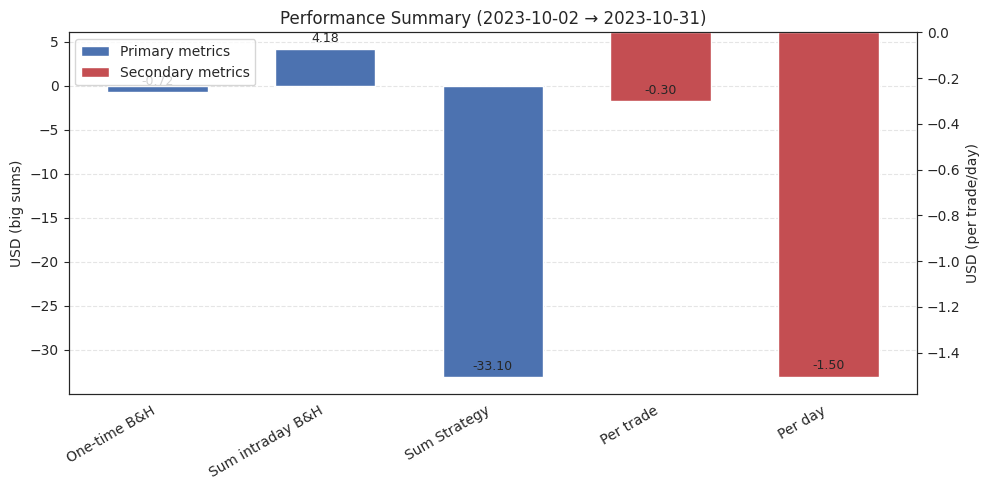


Overall Summary (2022-03-29 = 177.0727 → 2025-06-18 = 196.3926)

One-time buy&hold gain: 19.320
Buy & Hold – each day ($): -192.076
Strategy Return ($): -1173.309
Trades Count: 4471
Strategy return per trade: -0.262
Num. trading days: 809
Strategy return per trading day: -1.450


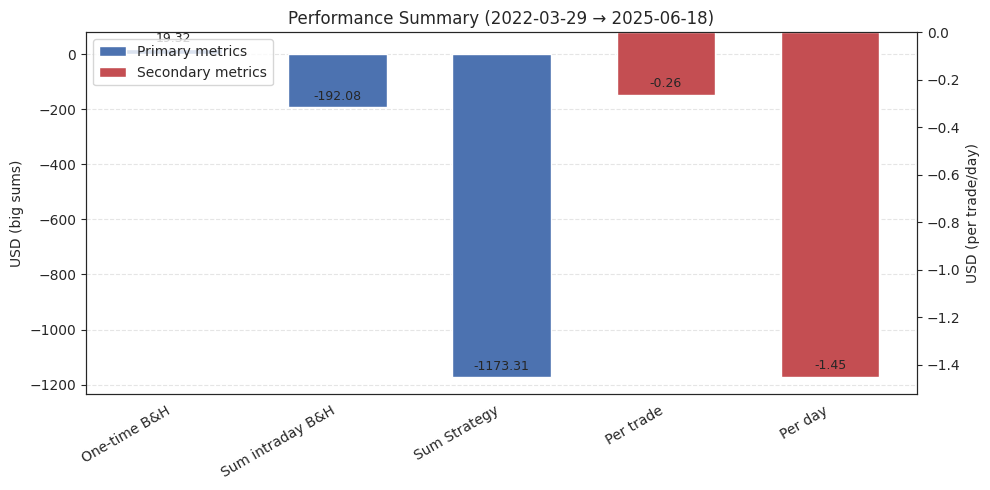

In [33]:
year, month = map(int, params.month_to_check.split("-"))

# 1) Build lists of days in that month + accumulate ALL days
days_in_month = []
performance_month = []
performance_all   = []

for day, (df_sim, trades_list, perf_stats) in sim_results.items():
    # always collect for the global summary
    performance_all.append(perf_stats)

    # pick out this month for plotting
    if day.year == year and day.month == month:
        days_in_month.append(day)
        performance_month.append(perf_stats)

feat_sel = df_feat_sel.columns.drop(['bid','ask','signal'])

# 2) Plot & print per-day stats for the month
if not days_in_month:
    print(f"No simulation data for {params.month_to_check}")
else:
    print(f"\nPlotting days in {params.month_to_check}:")
    for day in days_in_month:
        df_sim, trades_list, perf_stats = sim_results[day]
        plots.plot_trades(
            df                = df_sim,
            col_signal1       = "signal",
            col_signal2       = "pred_signal",
            col_action        = "pred_action",
            trades            = trades_list,
            buy_threshold     = params.pred_threshold_tick,
            performance_stats = perf_stats,
            col_close         = 'close_mid',
            features          = feat_sel
        )
        
        print(f"\n=== Performance for {day} ===")
        for k, v in perf_stats.items():
            print(f"{k}: {v}")
        print(f"\n---------------------------------------------------------------------------------------------------------------------------------------------------\n")

# 3) Monthly summary
df_month = df_test[df_test.index.to_period("M") == params.month_to_check]
plots.aggregate_performance(performance_month, df_month)

# 4) Overall summary across ALL days, with date range
plots.aggregate_performance(performance_all, df_test)